# Pairwise Experiments

### Setup

In [1]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(override=True)

True

### Task

Let's set up a new task! Here, we have a salesperson named Bob. Bob has a lot of deals, so he wants to summarize what happened in this deals based off of some meeting transcripts.

Bob is iterating on a few different prompts, that will give him nice, concise transcripts for his deals.

Bob has curated a dataset of his deal transcripts, let's go ahead and load that in. You can take a look at the dataset as well if you're curious! Note that this is not a golden dataset, there is no reference output here.

In [2]:
from langsmith import Client

client = Client()
dataset = client.clone_public_dataset(
  "https://smith.langchain.com/public/9078d2f1-7bef-4ba7-b795-210a17682ef9/d"
)

### Experiments

Now, let's run some experiments on this dataset using two different prompts. Let's add an evaluator that tries to score how good our summaries are!

In [3]:
from pydantic import BaseModel, Field
from openai import OpenAI

openai_client = OpenAI()

SUMMARIZATION_SYSTEM_PROMPT = """You are a judge, aiming to score how well a summary summarizes the content of a transcript"""

SUMMARIZATION_HUMAN_PROMPT = """
[The Meeting Transcript] {transcript}
[The Start of Summarization] {summary} [The End of Summarization]"""

class SummarizationScore(BaseModel):
    score: int = Field(description="""A score from 1-5 ranking how good the summarization is for the provided transcript, with 1 being a bad summary, and 5 being a great summary""")
    
def summary_score_evaluator(inputs: dict, outputs: dict) -> list:
    completion = openai_client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=[
            {   
                "role": "system",
                "content": SUMMARIZATION_SYSTEM_PROMPT,
            },
            {
                "role": "user",
                "content": SUMMARIZATION_HUMAN_PROMPT.format(
                    transcript=inputs["transcript"],
                    summary=outputs.get("output", "N/A"),
                )}
        ],
        response_format=SummarizationScore,
    )

    summary_score = completion.choices[0].message.parsed.score
    return {"key": "summary_score", "score": summary_score}

First, we'll run our experiment with a good version of our prompt!

In [4]:
# Prompt One: Good Prompt!
def good_summarizer(inputs: dict):
    response = openai_client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": f"Concisely summarize this meeting in 3 sentences. Make sure to include all of the important events. Meeting: {inputs['transcript']}"
            }
        ],
    )
    return response.choices[0].message.content

client.evaluate(
    good_summarizer,
    data=dataset,
    evaluators=[summary_score_evaluator],
    experiment_prefix="Good Summarizer"
)

/Users/sunainagoel/Desktop/langsmith/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


View the evaluation results for experiment: 'Good Summarizer-3e045577' at:
https://smith.langchain.com/o/54f14e87-ff07-44be-8054-7d3057dedd08/datasets/ba03ef38-5022-4a06-9a7d-bace029c9717/compare?selectedSessions=00c621ec-669e-40e5-962e-11935671c4cf




5it [00:14,  2.93s/it]


,inputs.transcript,outputs.output,error,feedback.summary_score,execution_time,example_id,id
0,"Bob and Ms. Thompson (NO DEAL): Bob: Hi, Ms. T...",Ms. Thompson visited Ford Motors to browse opt...,None,5,3.004220,2459b1d1-1780-44de-a105-ff22687a8827,b438a6f7-bb6f-4575-b768-c76d323ee307
1,Bob and Mr. Carter (CLOSED DEAL): Bob: Welcome...,Bob and Mr. Carter discussed trading in Mr. Ca...,None,5,2.475171,41ce7157-d630-40f4-bf80-5aab09cf7934,c72f9829-1d2d-4fd2-9a00-5e7958df15e0
2,Bob and Ms. Nguyen (NO DEAL): Bob: Good aftern...,Bob and Ms. Nguyen discussed various vehicle o...,None,5,1.581921,ae54530d-9399-47a2-86f5-ef46760d156b,1d2fd616-3c54-414b-9869-92c61ba2ba51
3,"Bob and Mr. Patel (CLOSED DEAL): Bob: Hello, M...",Bob assisted Mr. Patel in selecting a Ford Fus...,None,5,1.389410,b03783a3-1f4b-48ba-96ca-2023aac7ddf9,adeecc23-fe28-444d-84a4-b479e8603ec0
4,Bob and Mr. Johnson (CLOSED DEAL): Bob: Good m...,Bob introduced Mr. Johnson to the Ford Explore...,None,5,2.028961,d1e61942-9b9b-4d28-8808-8e39b0b8f848,a8fa9f39-1538-4c1e-9206-94ed3291108c


Now, we'll run an experiment with a worse version of our prompt, to highlight the difference.

In [5]:
# Prompt Two: Worse Prompt!
def bad_summarizer(inputs: dict):
    response = openai_client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": f"Summarize this in one sentence. {inputs['transcript']}"
            }
        ],
    )
    return response.choices[0].message.content

client.evaluate(
    bad_summarizer,
    data=dataset,
    evaluators=[summary_score_evaluator],
    experiment_prefix="Bad Summarizer"
)

View the evaluation results for experiment: 'Bad Summarizer-630b01e6' at:
https://smith.langchain.com/o/54f14e87-ff07-44be-8054-7d3057dedd08/datasets/ba03ef38-5022-4a06-9a7d-bace029c9717/compare?selectedSessions=baa12a84-3f36-4e92-8bd8-c0e165efc99b




5it [00:10,  2.10s/it]


,inputs.transcript,outputs.output,error,feedback.summary_score,execution_time,example_id,id
0,"Bob and Ms. Thompson (NO DEAL): Bob: Hi, Ms. T...",Ms. Thompson is browsing for an SUV and may bu...,None,4,1.545495,2459b1d1-1780-44de-a105-ff22687a8827,8eb7be49-be8b-4e36-916a-d1a32e230a8b
1,Bob and Mr. Carter (CLOSED DEAL): Bob: Welcome...,Bob successfully facilitated a trade-in deal f...,None,5,1.057988,41ce7157-d630-40f4-bf80-5aab09cf7934,f269dd24-d293-4ba4-9815-12e68609c895
2,Bob and Ms. Nguyen (NO DEAL): Bob: Good aftern...,Bob and Ms. Nguyen discuss various vehicle opt...,None,5,1.080600,ae54530d-9399-47a2-86f5-ef46760d156b,62ffe183-5d55-4fa6-9c8b-e16170aa2a4d
3,"Bob and Mr. Patel (CLOSED DEAL): Bob: Hello, M...",Bob helped Mr. Patel finalize a purchase of a ...,None,4,1.116310,b03783a3-1f4b-48ba-96ca-2023aac7ddf9,ff62b0b8-0d68-49b9-850c-9eb1e1c78d79
4,Bob and Mr. Johnson (CLOSED DEAL): Bob: Good m...,Bob successfully helped Mr. Johnson choose and...,None,5,1.373693,d1e61942-9b9b-4d28-8808-8e39b0b8f848,e371915f-c394-4e18-935c-9e2ee19da357


### Pairwise Experiment

Let's define a function that will compare our two experiments. These are the fields that pairwise evaluator functions get access to:
- `inputs: dict`: A dictionary of the inputs corresponding to a single example in a dataset.
- `outputs: list[dict]`: A list of the dict outputs produced by each experiment on the given inputs.
- `reference_outputs: dict`: A dictionary of the reference outputs associated with the example, if available.
- `runs: list[Run]`: A list of the full Run objects generated by the experiments on the given example. Use this if you need access to intermediate steps or metadata about each run.
- `example: Example`: The full dataset Example, including the example inputs, outputs (if available), and metdata (if available).

First, let's give our LLM-as-Judge some instructions. In our case, we're just going to directly use LLM-as-judge to grade which of the summarizers is the most helpful.

It might be hard to grade our summarizers without a ground truth reference, but here, comparing different prompts head to head will give us a sense of which is better!

In [6]:
JUDGE_SYSTEM_PROMPT = """
Please act as an impartial judge and evaluate the quality of the summarizations provided by two AI summarizers to the meeting transcript below.
Your evaluation should consider factors such as the helpfulness, relevance, accuracy, depth, creativity, and level of detail of their summarizations. 
Begin your evaluation by comparing the two summarizations and provide a short explanation. 
Avoid any position biases and ensure that the order in which the responses were presented does not influence your decision. 
Do not favor certain names of the assistants. 
Be as objective as possible. """

JUDGE_HUMAN_PROMPT = """
[The Meeting Transcript] {transcript}

[The Start of Assistant A's Summarization] {answer_a} [The End of Assistant A's Summarization]

[The Start of Assistant B's Summarization] {answer_b} [The End of Assistant B's Summarization]"""

Our function will take in an `inputs` dictionary, and a list of `outputs` dictionaries for the different experiments that we want to compare.

In [7]:
from pydantic import BaseModel, Field

class Preference(BaseModel):
    preference: int = Field(description="""1 if Assistant A answer is better based upon the factors above.
2 if Assistant B answer is better based upon the factors above.
Output 0 if it is a tie.""")
    
def ranked_preference(inputs: dict, outputs: list[dict]) -> list:
    completion = openai_client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=[
            {   
                "role": "system",
                "content": JUDGE_SYSTEM_PROMPT,
            },
            {
                "role": "user",
                "content": JUDGE_HUMAN_PROMPT.format(
                    transcript=inputs["transcript"],
                    answer_a=outputs[0].get("output", "N/A"),
                    answer_b=outputs[1].get("output", "N/A")
                )}
        ],
        response_format=Preference,
    )

    preference_score = completion.choices[0].message.parsed.preference

    if preference_score == 1:
        scores = [1, 0]
    elif preference_score == 2:
        scores = [0, 1]
    else:
        scores = [0, 0]
    return scores

Now let's run our pairwise experiment with `evaluate()`

In [10]:
from langsmith import evaluate

evaluate(
    ("Good Summarizer-3e045577", "Bad Summarizer-630b01e6"),  # TODO: Replace with the names/IDs of your experiments
    evaluators=[ranked_preference]
)

View the pairwise evaluation results at:
https://smith.langchain.com/o/54f14e87-ff07-44be-8054-7d3057dedd08/datasets/ba03ef38-5022-4a06-9a7d-bace029c9717/compare?selectedSessions=00c621ec-669e-40e5-962e-11935671c4cf%2Cbaa12a84-3f36-4e92-8bd8-c0e165efc99b&comparativeExperiment=e73bae3c-6f37-4ee8-8e56-65e17ac518b5




100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


When we compared them head to head we could see that the llm always prefers the good prompt in all the 5 cases, even though independently their evaluation scores were the same

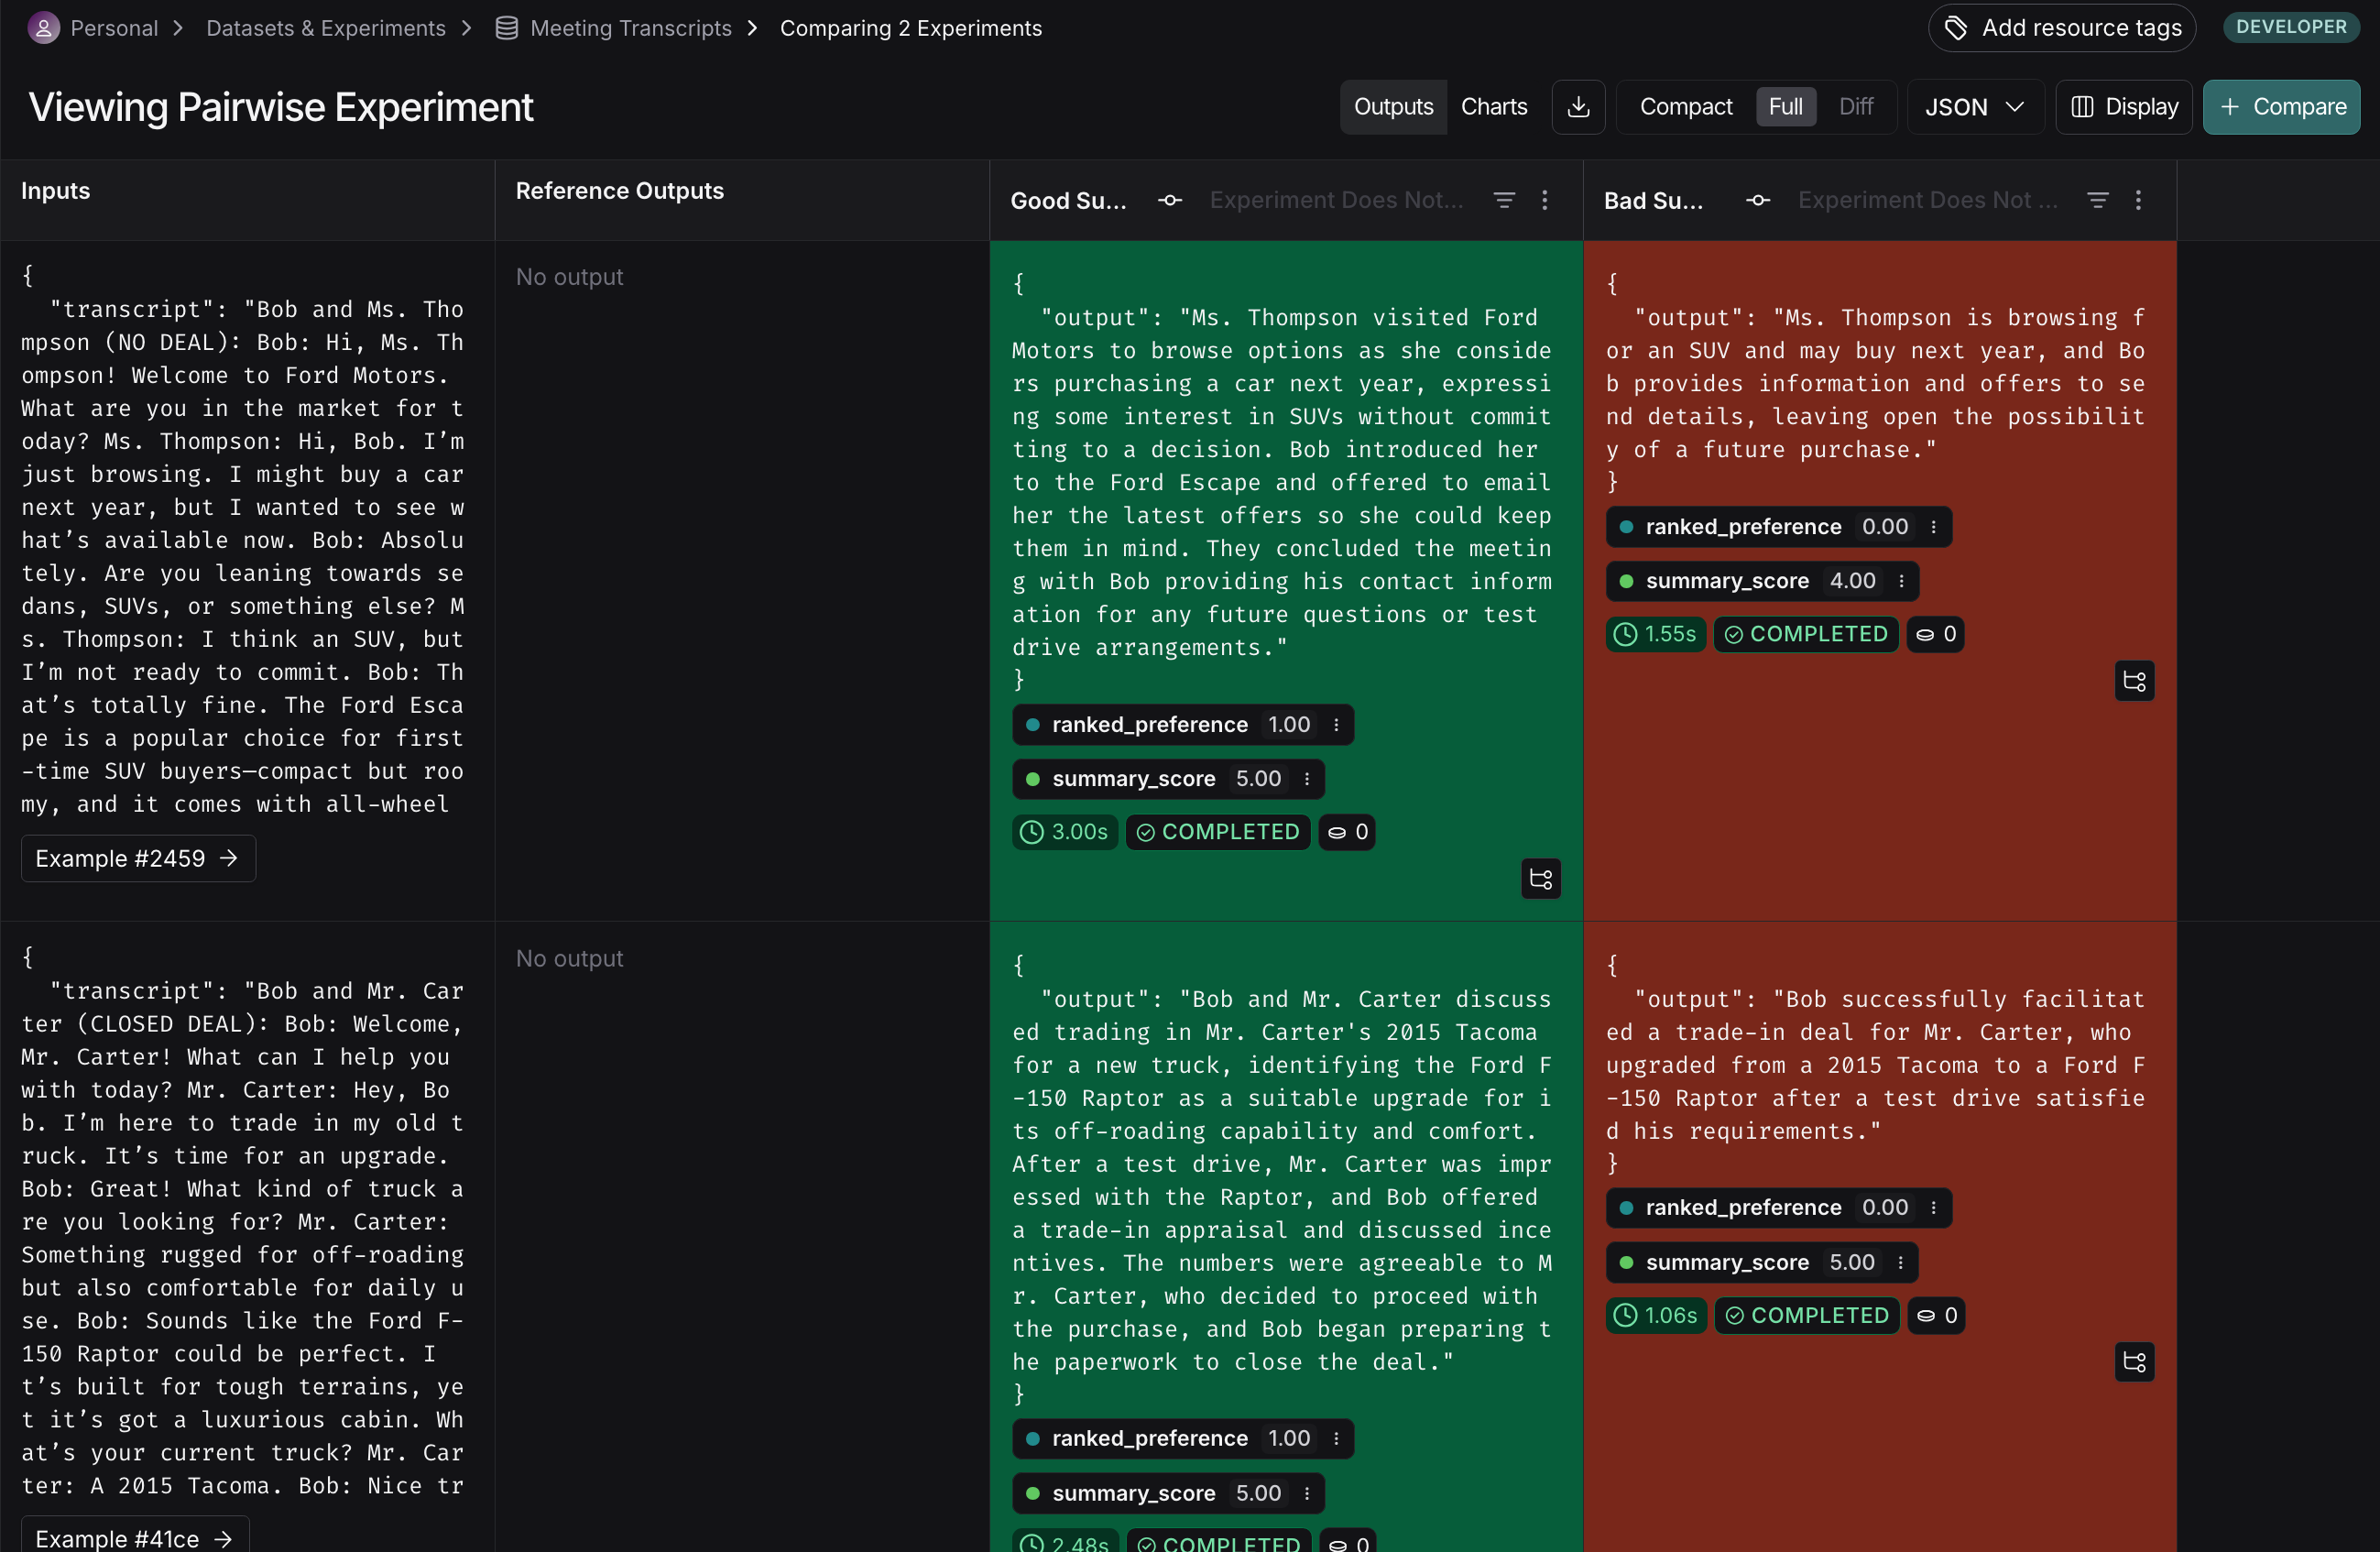